## 9.5 Non-seasonal ARIMA models

If we combine differencing with autoregression and a moving average model, we obtain a non-seasonal ARIMA model. ARIMA is an acronym for **AutoRegressive Integrated Moving Average** (in this context, "integration" is the reverse of differencing). The full model can be written as
$$
y'_t = c + \phi_1 y'_{t-1} + \cdots+\phi_py'_{t-p} + \theta_1\epsilon_{t-1}+\cdots+\theta_q\epsilon_{t-q} + \epsilon_t,
$$
where $y_t'$ is the differenced series (it may have been differenced more than once). The "predictors" on the right hand side include both lagged values of $y_t$ and lagged errors. We call this an $\text{ARIMA}(p, d, q)$ model, where
$$
\begin{align*}
p & = \text{order of the autoregressive part}; \\
d & = \text{degree of first differencing involved}; \\
q & = \text{order of the moving average part.}
\end{align*}
$$
The same stationarity and invertibility conditions that are used for autoregressive and moving average models also apply to an ARIMA model. 
Many of the models we have discussed are special cases of the ARIMA model:

| Model | Description |
|---|---|
| White noise | $\text{ARIMA}(0,0,0)$ with no constant |
| Random walk | $\text{ARIMA}(0,1,0)$ with no constant |
| Random walk with drift | $\text{ARIMA}(0,1,0)$ with a constant |
| Autoregression | $\text{ARIMA}(p,0,0)$ |
| Moving average | $\text{ARIMA}(0,0,q)$ |

Once we start combining components in this way to form more complicated models, it is much easier to work with the backshift notation. For example, the above equation can be written in backshift notation as

$$
\begin{align*}
\underbrace{(1 - \phi_1 B - \cdots - \phi_p B^p)}_{\text{AR($p$)}} 
\underbrace{(1 - B)^d}_{\text{$d$ differences}} y_t 
= c + 
\underbrace{(1 + \theta_1 B + \cdots + \theta_q B^q)}_{\text{MA($q$)}} \varepsilon_t
\end{align*}
$$

Selecting appropriate values fo $p$, $d$ and $q$ can be difficult. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from utils import *

In [5]:
from get_data import global_economy

In [17]:
egypt_econ = (global_economy.query("Code == 'EGY'")
.assign(date=lambda df: pd.to_datetime(df.Year, format="%Y"))
.set_index("date")
.pipe(set_freq)
).Exports

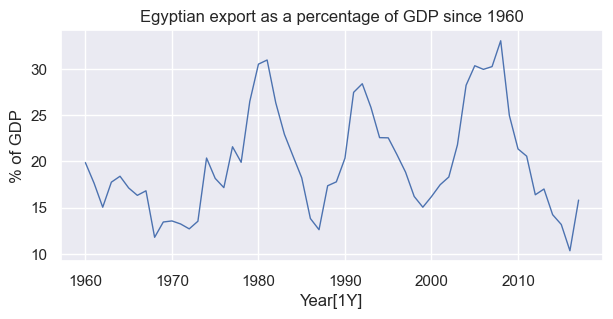

In [18]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(egypt_econ)
ax.set(
    xlabel="Year[1Y]",
    ylabel="% of GDP",
    title="Egyptian export as a percentage of GDP since 1960",
);

In [21]:
fit = sm.tsa.SARIMAX(endog=egypt_econ, order=(2, 0, 1), trend='c').fit(disp=0)

In [36]:
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Exports   No. Observations:                   58
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -141.566
Date:                Fri, 22 Nov 2024   AIC                            293.132
Time:                        20:30:31   BIC                            303.434
Sample:                    01-01-1960   HQIC                           297.145
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5615      1.041      2.462      0.014       0.522       4.601
ar.L1          1.6765      0.127     13.242      0.000       1.428       1.925
ar.L2         -0.8034      0.102     -7.906      0.0

In [24]:
fc = fit.get_forecast(10)

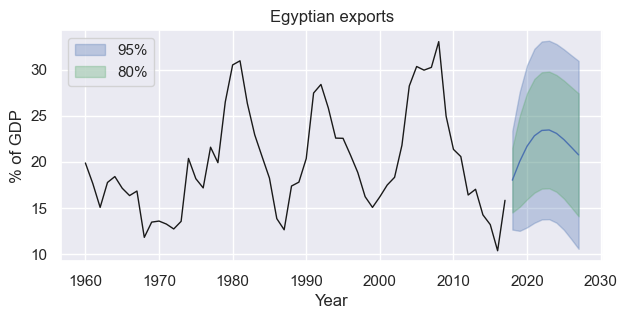

In [35]:
f, ax = plt.subplots(figsize=(7, 3))
ax.plot(egypt_econ, 'k')
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3, label='95%')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C2', alpha=.3, label='80%')
ax.legend()
ax.set(xlabel='Year', ylabel='% of GDP', title='Egyptian exports');

### ACF and PACF plots
It is usually not possible to tell, simply from a time plot, what values of $p$ and $q$ are appropriate for the data. However, it is sometimes possible to use the ACF plot, and the closely related PACF plot, to determine appropriate values for $p$ and $q$. 

The ACF plot shows the autocorrelations which measure the relationship between $y_t$ and $y_{t-k}$ for different values of $k$. This has the problem that if $y_t$ and $y_{t-2}$ are correlated, it could simply be because that $y_t$ and $y_{t-1}$ are correlated and $y_{t-1}$ and $y_{t-2}$ are correlated, rather than because of any new information contained in $y_{t-2}$ that could be used in forecasting $y_t$. 

To overcome this problem, we can use partial autocorrelations. These measure the relationship between $y_t$ and $y_{t-k}$ after removing the effects of lags $1, 2, 3,\cdots,k-1$. So the first partial autocorrelation is identical to the first autocorrelation, because there is nothing between them to remove. Each partial autocorrelation can be estimated as the last coefficient in an autoregressive model. Specifically, $\alpha_k$, the $k$th partial autocorrelation coefficient, is equal to the estimate of $\phi_k$ in an AR($k$) model. 


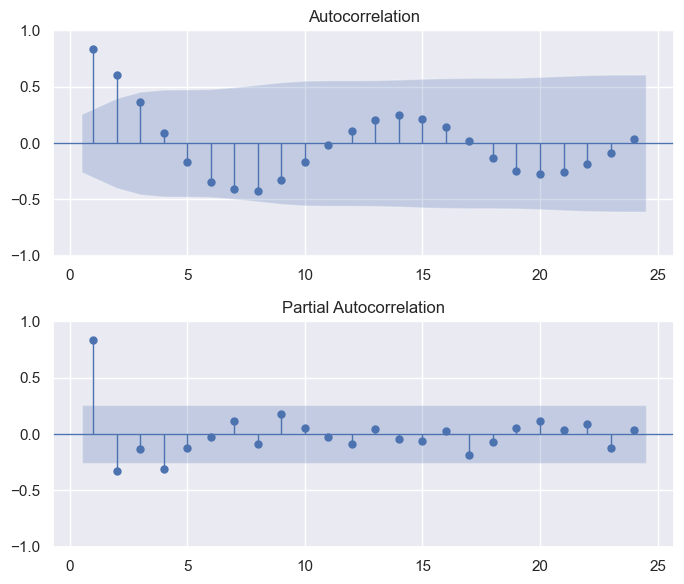

In [40]:
fig, axes = plt.subplots(2, figsize=(7, 6))
lags = np.r_[1:25]
sm.graphics.tsa.plot_acf(egypt_econ, lags=lags, ax=axes[0]); # Autocorrelation
sm.graphics.tsa.plot_pacf(egypt_econ, lags=lags, ax=axes[1]); # Partial autocorrelation
plt.tight_layout();

If the data are from an $\text{ARIMA}(p, d, 0)$ or $\text{ARIMA}(0, d, q)$ model, then the ACF and PACF plots can be helpful in determining the value of $p$ or $q$. If both $p$ and $q$ are positive, then the plots do not help in finding suitable values of $p$ and $q$. 

The data may follow an $\text{ARIMA}(p, d, 0)$ model if the ACF and PACF plots of the differenced data show the following patterns:
- the ACF is exponentially decaying or sinusoidal;
- there is a significant spike at lag $p$ in the PACF, but none beyond lag $p$.

The day may follow an $\text{ARIMA}(0, d, q)$ model if the ACF and PACF plots of the differenced data show the following patterns:
- the PACF is exponentially decaying or sinusoidal
- there is a significant spike at lag $q$ in the ACF, but none beyond lag $q$. 

From the figure above, we see there is a decaying sinusoidal pattern in the ACF, and PACF shows the last significant spike at lag 4. This is what you would expect from an $\text{ARIMA}(4, 0, 0)$ model.

In [41]:
fit = sm.tsa.SARIMAX(endog=egypt_econ, order=(4, 0, 0), trend='c').fit(disp=0)

In [42]:
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Exports   No. Observations:                   58
Model:               SARIMAX(4, 0, 0)   Log Likelihood                -140.526
Date:                Fri, 22 Nov 2024   AIC                            293.051
Time:                        20:47:10   BIC                            305.414
Sample:                    01-01-1960   HQIC                           297.867
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.6914      1.455      4.599      0.000       3.840       9.543
ar.L1          0.9861      0.140      7.041      0.000       0.712       1.261
ar.L2         -0.1715      0.207     -0.829      0.4

This model performs very similarly to the one above, with an AIC value of 293.05 compared to 293.132 from the ARIMA(2, 0, 1) model.